In [23]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('metrics.csv')
df = df.drop_duplicates(subset=['Type Name'])
df = df.drop(['Project.Package Name', 'Method Name', 'MLOC', 'CC', 'PC', 'Abstract Function Call From Constructor', 'Complex Conditional', 
              'Complex Method', 'Empty catch clause', 'Long Identifier', 'Long Method', 'Long Parameter List',
              'Long Statement', 'Missing default', 'Deficient encapsulation', 'Unexploited modularization',
             'Broken modularization', 'Cyclically-dependent modularization', 'Hub-like modularization', 'Insufficient modularization',
             'Broken hierarchy', 'Cyclic hierarchy', 'Deep hierarchy', 'Missing hierarchy','Missing hierarchy',
             'Multipath hierarchy', 'Rebellious hierarchy', 'Wide hierarchy'], axis=1)

df.set_index('Type Name', inplace = True)
df.head()

,NOF,NOPF,NOM,NOPM,LOC,WMC,NC,DIT,LCOM,FANIN,FANOUT,Magic Number
Type Name,,,,,,,,,,,,
CachedThreadPool,0,0,1,1,12,2,0,0,-1.0,0,0,1
Sleeper,1,0,2,2,21,2,0,0,0.0,0,0,0
Joiner,1,0,2,2,17,2,0,0,0.0,0,0,0
Joining,0,0,1,1,7,1,0,0,-1.0,0,0,1
FixedThreadPool,0,0,1,1,12,2,0,0,-1.0,0,0,1


In [34]:
train_x = df.iloc[:,0:11]
train_y = df.iloc[:,11:12]
train_y


,Magic Number
Type Name,
CachedThreadPool,1
Sleeper,0
Joiner,0
Joining,1
FixedThreadPool,1
...,...
TestMailer,0
TestMessageDigestPasswordEncoder,0
TestJavaMelodyLogger,0


In [36]:
from sklearn.decomposition import PCA

mypca = PCA(n_components = 2)
PCA_train_x = mypca.fit_transform(train_x)

In [37]:
print('PCA_train_x shape: ', PCA_train_x.shape)

PCA_train_x shape:  (110866, 2)


Text(0, 0.5, 'Principal Component 2')

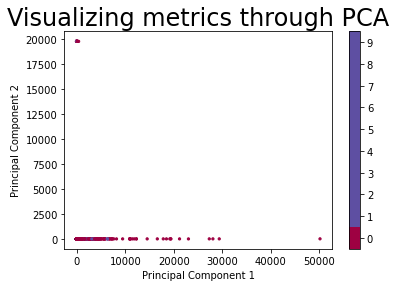

In [41]:
## Plot on the graph
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], s = 5, c = train_y['Magic Number'], cmap = 'Spectral')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

plt.title('Visualizing metrics through PCA', fontsize=24);
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

In [42]:
sub_PCA_train_x = PCA_train_x[:1000, :]
print('sub_PCA_train_x.shape: ', sub_PCA_train_x.shape)

sub_PCA_train_x.shape:  (1000, 2)


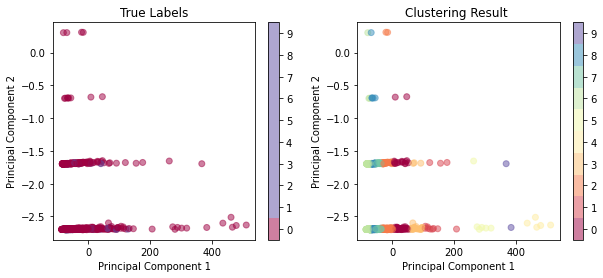

In [43]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

hier = AgglomerativeClustering(n_clusters = 10, affinity = 'euclidean')
hier_clusters = hier.fit(sub_PCA_train_x)

## Plot 
plt.figure(figsize = (10, 4))
plt.subplot(1, 2, 1)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c = train_y['Magic Number'][:1000], cmap = 'Spectral', alpha = 0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("True Labels")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], c=hier_clusters.labels_[:1000], cmap='Spectral', alpha=0.5)
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title("Clustering Result ")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Apply k-means

In [44]:
def apply_normalizer(dataset, offset, divisor):
    dataset_normalized = np.zeros(dataset.shape)
    N = dataset.shape[0]
    dataset_normalized = dataset-np.tile(offset, (N,1))
    dataset_normalized = dataset_normalized / np.tile(divisor, (N,1))

    return dataset_normalized


def normalize_minmax(dataset):
    minval = dataset.min(0)
    maxval = dataset.max(0)
    
    dataset_normalized = apply_normalizer(dataset, minval, maxval-minval)

    return dataset_normalized, minval, maxval-minval


def normalize_meanstd(dataset):
    meanval = dataset.mean(0)
    stdval = dataset.std(0)

    dataset_normalized = apply_normalizer(dataset, meanval, stdval)

    return dataset_normalized, meanval, stdval



In [45]:
normalized_PCA_train_x, off, div = normalize_minmax(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div, '\n')

normalized_PCA_train_x, off, div = normalize_meanstd(sub_PCA_train_x)
print("Original data: ", sub_PCA_train_x[0], '\nNormalized data: ', normalized_PCA_train_x[0])
print("offset:", off, ";  divisor:", div)

Original data:  [-76.14270542  -2.69774375] 
Normalized data:  [0.015113   0.00234392]
offset: [-85.16900981  -2.70480887] ;  divisor: [597.2541215   3.0142244] 

Original data:  [-76.14270542  -2.69774375] 
Normalized data:  [-0.49348198 -0.46066248]
offset: [-44.57518735  -2.49019975] ;  divisor: [63.9689379   0.45053378]


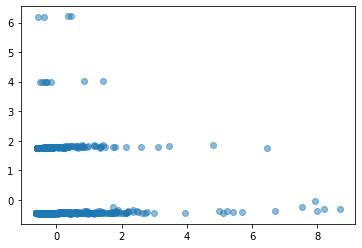

In [46]:
plt.scatter(normalized_PCA_train_x[:, 0], normalized_PCA_train_x[:, 1], cmap='Spectral', alpha=0.5)

In [47]:
# a distance function
def Euclidean_distance(vecA, vecB):
    return np.sqrt(sum(np.power([a - b for a, b in zip(vecA, vecB)], 2)))

In [58]:
k = int(input("How many cluster do you want? "))
print(k)

How many cluster do you want? 4
4


In [59]:
import random

def init_centroids_random(dataset, k):
    centroids = {}
    init_centroids = random.sample(range(0, len(dataset)), k)
    
    for i, c in enumerate(init_centroids):
            centroids[i] = dataset[i]
    return centroids

In [60]:
def init_centroids_index(dataset, k):
    centroids = {}
    for i in range(k):  # first k instances become the initial centroids
        centroids[i] = dataset[i]
    return centroids

In [61]:
# initialize_centroids(centroids, sub_PCA_train_x)
centroids = init_centroids_random(sub_PCA_train_x, k)

In [62]:
# Change centroids value to dataframe. 
cet_df = pd.DataFrame(centroids).transpose()
cet_df.columns = ['X', 'Y']
cet_df.head()

,X,Y
0,-76.142705,-2.697744
1,-67.176452,-2.697644
2,-71.067691,-2.697141
3,-81.193497,-2.697760


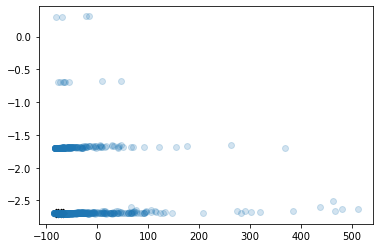

In [63]:
# Plot random centroids on the dataset
plt.figure()
plt.scatter(cet_df['X'], cet_df['Y'], color='black', marker='D')
plt.scatter(sub_PCA_train_x[:, 0], sub_PCA_train_x[:, 1], alpha=0.2)

In [64]:
def re_assign_data(dataset, centroids):
    # (Re)assigning every instance to its closest centroid
    cluster_memberships = {}
    for i in centroids:
        cluster_memberships[i] = []
    
    for row in dataset:
        # Calculate euclidean distance between each centroid and each data.
        dist_to_centroids = [Euclidean_distance(row, centroids[c]) for c in centroids]
        
        # Find the centroid with a minimum distance 
        membership = dist_to_centroids.index(min(dist_to_centroids))
        cluster_memberships[membership].append(row)
        
    return cluster_memberships

In [65]:
def re_calc_avg_sse(centroids, cluster_memberships):    
    # Re-calculate the average of each cluster and calculate SSE.
    curr_sse = 0
    
    for membership in cluster_memberships:
        centroids[membership] = np.average(cluster_memberships[membership], axis=0)

        for row in cluster_memberships[membership]:
            curr_sse += np.power(Euclidean_distance(row, centroids[membership]), 2)
    
    return centroids, curr_sse 

In [66]:
## k-Means algorithm
def kmeans(dataset, k, max_iter = 300, tol = 0.001):
    centroids = init_centroids_random(dataset, k)
    
    ## 1. Initiate SSE which is key metric in k-means clustering (sse = sum of squared error) into 'np.inf'
    curr_sse = np.inf
    

    ## 2. Clustering
    for i in range(max_iter):

        ## (Re)Aassign datas to its closest centroids
        cluster_memberships = re_assign_data(dataset, centroids)

        ## Re-calculate the average of each cluster and calculate SSE.
        prev_sse = curr_sse
        centroids, curr_sse = re_calc_avg_sse(centroids, cluster_memberships)

        ## Plot center points
        plt.figure(i)
        c_df = pd.DataFrame(centroids).transpose()
        plt.scatter(c_df.loc[:, 0], c_df.loc[:, 1], color='black', marker='x')

        ## Plot assigned data
        for key in cluster_memberships:
            plt.scatter(*zip(*cluster_memberships[key]), alpha=0.2)
            plt.title('k={} '.format(k) + ' SSE=' + str(curr_sse))

        plt.show()
        print('iteration#{} | prev_sse= {:.4f};  curr_sse= {:.4f}'.format(i, prev_sse, curr_sse))

        # Terminal Condition
        if (prev_sse - curr_sse) / curr_sse < tol:
            break

    return cluster_memberships, curr_sse

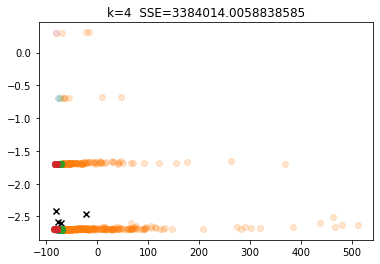

iteration#0 | prev_sse= inf;  curr_sse= 3384014.0059


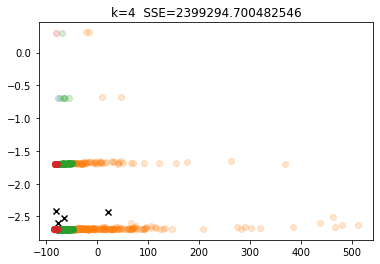

iteration#1 | prev_sse= 3384014.0059;  curr_sse= 2399294.7005


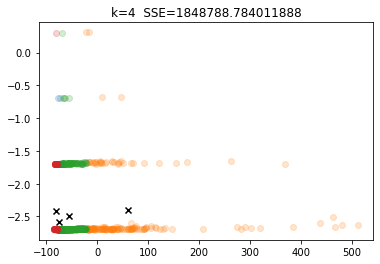

iteration#2 | prev_sse= 2399294.7005;  curr_sse= 1848788.7840


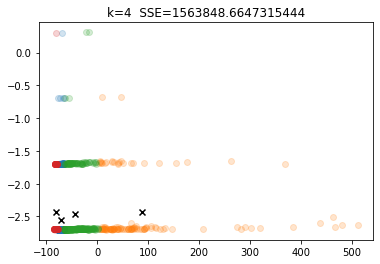

iteration#3 | prev_sse= 1848788.7840;  curr_sse= 1563848.6647


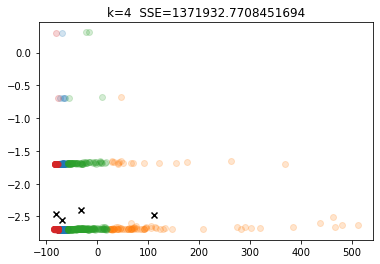

iteration#4 | prev_sse= 1563848.6647;  curr_sse= 1371932.7708


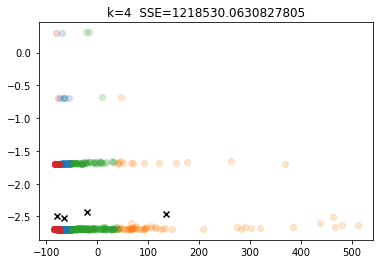

iteration#5 | prev_sse= 1371932.7708;  curr_sse= 1218530.0631


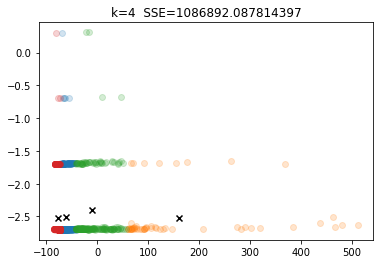

iteration#6 | prev_sse= 1218530.0631;  curr_sse= 1086892.0878


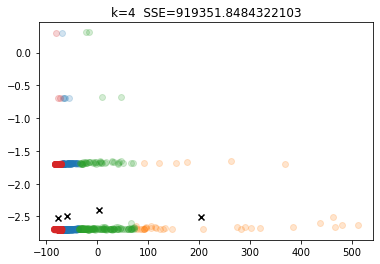

iteration#7 | prev_sse= 1086892.0878;  curr_sse= 919351.8484


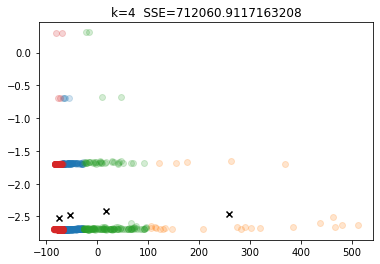

iteration#8 | prev_sse= 919351.8484;  curr_sse= 712060.9117


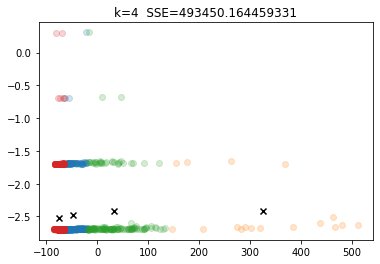

iteration#9 | prev_sse= 712060.9117;  curr_sse= 493450.1645


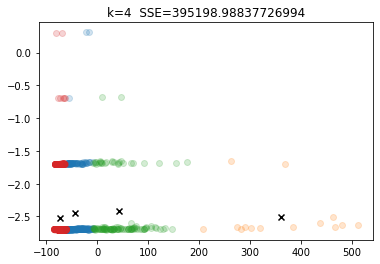

iteration#10 | prev_sse= 493450.1645;  curr_sse= 395198.9884


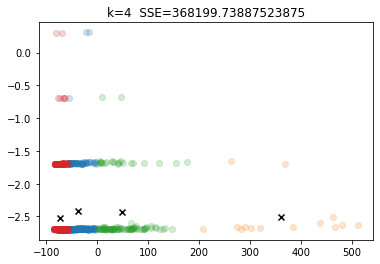

iteration#11 | prev_sse= 395198.9884;  curr_sse= 368199.7389


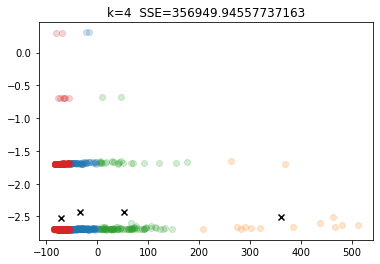

iteration#12 | prev_sse= 368199.7389;  curr_sse= 356949.9456


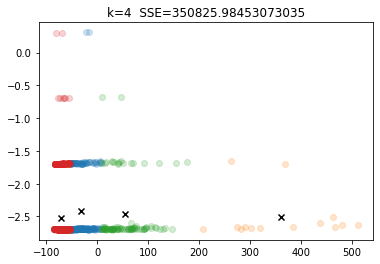

iteration#13 | prev_sse= 356949.9456;  curr_sse= 350825.9845


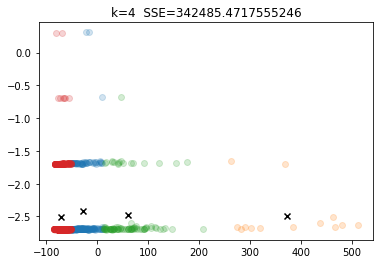

iteration#14 | prev_sse= 350825.9845;  curr_sse= 342485.4718


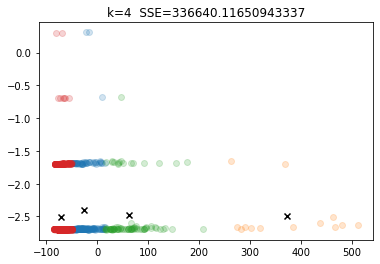

iteration#15 | prev_sse= 342485.4718;  curr_sse= 336640.1165


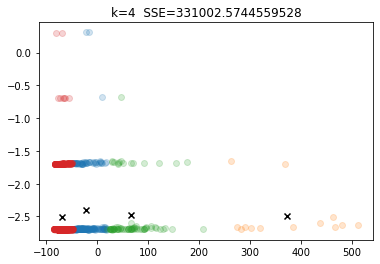

iteration#16 | prev_sse= 336640.1165;  curr_sse= 331002.5745


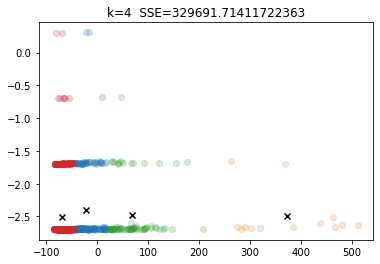

iteration#17 | prev_sse= 331002.5745;  curr_sse= 329691.7141


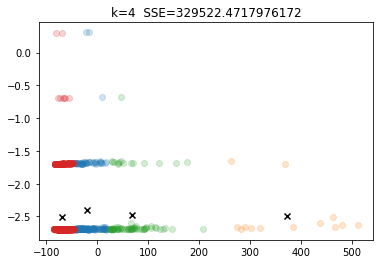

iteration#18 | prev_sse= 329691.7141;  curr_sse= 329522.4718


In [67]:
cluster_memberships, curr_sse = kmeans(sub_PCA_train_x, k)